# **Machine Learning Applications Final Project Notebook**

Date: May 9, 2023

Authors: Óscar Montoya Amores (100451858), Javier Serrano Sánchez-Ocaña (100451673), Miguel Ángel Ponce Martínez (100451309)

#### **LIBRARIES IMPORT**

In [2]:
import numpy as np
import pandas as pd
import zipfile as zp
from termcolor import colored
import seaborn as sns
import matplotlib.pyplot as plt

import spacy    

## **0. Dataset Loading and DF Preprocessing**

#### **DATASET IMPORT**

Let's load the dataset obtained from Kaggle (https://www.kaggle.com/datasets/elizzyliu/song-lyrics) and obtain the main insights from this data:

In [3]:
df = pd.read_csv('all_lyrics.csv')

display(df)

,song,artist,type,lyrics
0,Stairway to Heaven,Led Zeppelin,rock,Stairway to Heaven Lyrics[Intro]\r\n\r\n[Verse...
1,Hey Jude,Beatles,rock,Hey Jude Lyrics[Verse 1: Paul McCartney]\r\nHe...
2,All Along the Watchtower,"Hendrix, Jimi",rock,"Ii. Tambourine Lyrics[Chorus, sung]\r\nHey, Pi..."
3,Satisfaction,Rolling Stones,rock,"Sin título I Lyrics[Letra de ""Sin título I""]\r..."
4,Like A Rolling Stone,"Dylan, Bob",rock,Like a Rolling Stone Lyrics[Verse 1]\r\nOnce u...
...,...,...,...,...
3995,Motown 25,Elzhi,rap & hip hop,Motown 25 Lyrics[Verse 1: eLZhi]\r\nI end care...
3996,How Ya Like Me Now,Kool Moe Dee,rap & hip hop,"How Ya Like Me Now Lyrics""All aboard for the n..."
3997,Coastin’,Zion I feat. K.Flay,rap & hip hop,Coastin’ LyricsWhen life brings trouble\r\nYou...
3998,Head Banger,EPMD,rap & hip hop,Headbanger Lyrics[Redman]\r\nNegroes!!!!!!!!\r...


In [4]:
df.describe()

,song,artist,type,lyrics
count,4000,4000,4000,3896
unique,3881,1583,4,3761
top,Summertime,Beatles,rock,Summer Country Songs LyricsA\r\nAaron Lewis – ...
freq,5,51,1000,10


This dataset is composed by the 1000 most famous songs from every musical genre(``type Variable``) and our goal is find some relation among songs lyrics and its genre. 

Firstly, null values seems to appear in the lyrics row because as we can see 104 songs ``lyrics`` are not counted properly. So first thing wee need to do is remove null values.

Moreover, the unique row bothers us too. It is expected that ``type`` and ``artist`` have several instances repeated (Artist could have many famous songs and obviously given 4 genres it will be repeated). Furthermore, even two different artists could present two different songs with the same name (``song``). However, it is really strange that two songs represent the same lyrics. Here we could have be talking about plagiarism, corrupted data or simply describe() function is not working as expected with long string stucture, so before starting to apply some Machine Learnings Applicatios we have seen in class we need to fix this trouble.

In [5]:
null = df['lyrics'].isna().values

print(f'There are exactly {sum(null)} null values in the lyrics variable which corresponds to the {sum(null)/len(null)*100:.3f}% of the data set')


There are exactly 104 null values in the lyrics variable which corresponds to the 2.600% of the data set


We think this percentege is assumible of being removed from the dataset but before doing so let's see the proportion of songs genre which receives null lyrics. 

<AxesSubplot:>

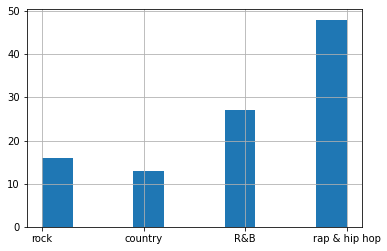

In [6]:
df_null = df[null]
df_null['type'].hist()

Most of the null lyrics are from ``rap & hip hop`` but nothing alarming. We can assume to remove this instances, update the dataframe and repeat a similar process to find out repeted lyrics. 

In [7]:
df = df.dropna(subset=['lyrics', 'type'])

In [8]:
print(df.duplicated().values)

[False False False ... False False False]


There are exactly 14 repeated values in the lyrics variable which corresponds to the 0.359% of the data set


<AxesSubplot:>

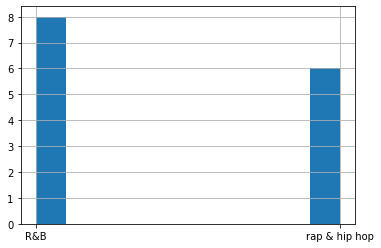

In [9]:
repeated = df[df.duplicated()]
print(f'There are exactly {len(repeated)} repeated values in the lyrics variable which corresponds to the {len(repeated)/len(df)*100:.3f}% of the data set')
repeated['type'].hist()

Again, the ammount of repeated values are not very important but this time is focused on only two genres. However, we will remove it because it is not adding any information and let's repeat the describe() process to finally start to focus on the Machine Learning Apps.

In [10]:
df = df.drop_duplicates(subset=['lyrics'], keep='first').reset_index(drop=True)
df.describe()

,song,artist,type,lyrics
count,3761,3761,3761,3761
unique,3668,1476,4,3761
top,Angel,Beatles,rock,Stairway to Heaven Lyrics[Intro]\r\n\r\n[Verse...
freq,5,48,972,1


Good news regarding the ``lyrics`` variable, is time to begin working with spacy and more NLP libaries we have seen during classes.

## **1. Text Preprocessing and vectorization**

### **1.1 NLP Pipeline**

Before the implementation of the Pipeline let's print some ``lyrics`` instances in order to visualize which kind of none useful set of characters has been introduced

In [11]:
instances = [l for l in df['lyrics'].values[:2]]

for si,s in enumerate(instances):
    print(f'SONG {si + 1}')
    print(str([s])+'\n')

SONG 1
["Stairway to Heaven Lyrics[Intro]\r\n\r\n[Verse 1]\r\nThere's a lady who's sure all that glitters is gold\r\nAnd she's buying a stairway to Heaven\r\nWhen she gets there she knows, if the stores are all closed\r\nWith a word she can get what she came for\r\nOoh, ooh, and she's buying a stairway to Heaven\r\nThere's a sign on the wall, but she wants to be sure\r\n'Cause you know sometimes words have two meanings\r\nIn a tree by the brook, there's a songbird who sings\r\nSometimes all of our thoughts are misgiven\r\n\r\n[Chorus]\r\nOoh, it  makes me wonder\r\nOoh, makes me wonder\r\n[Verse 2]\r\nThere's a feeling I get when I look to the West\r\nAnd my spirit is crying for leaving\r\nIn my thoughts I have seen rings of smoke through the trees\r\nAnd the voices of those who stand looking\r\n\r\n[Chorus]\r\nOoh, it makes me wonder\r\nOoh, really makes me wonder\r\n\r\n[Verse 3]\r\nAnd it's whispered that soon if we all call the tune\r\nThen the piper will lead us to reason\r\nAnd a

From these two songs we can clearly see that there are a lot of characters which is not necessary at all. Firstly it seems that at the beguining of every song, the title of the song it is included, an iformation wich is stored in other variable and we do not need. Also at the end of the song a sequence of numbers and 'Embed' word is appearing. Furthermore, every information inside '[]' is not corresponding to the lyrics itself. Finally, '/n' wich corresponds to line skip must be removed.

Regarding expresions like 'na', 'yeah', 'hey'... could be interpreted as some kind of stopword which maybe is not a word which express to much but especially in this second song for example it seems to be half of the song. So deppending on troubles we could face, we will change the decision of keeping this strings. However, contractions must be treated as a 'formal' word in orther to obtain the same meaning for every word. This can be counter benefit especially in ``rap & hip hop`` genre which most of the words uses contraction to fit with the rithm of the song. But at the end we are triying to find the meaning of the words in the song and each word must be represented in the same manner in every one.  

Creating a function to address all this problems would be the best manner to properly display the lyrics:

In [12]:
#Maximum length of any song's Title
lengthTitle = df['song'].apply(lambda x: len(x.split(' '))).values
maxLen = np.max(lengthTitle) + 5 #This 5 is just a margin just in case

In [13]:
import re
import contractions
import unicodedata

def correctLyrics(row, maxLen):
    text = row['lyrics']
    #1. Remove '\n' and Unicode Escape Sequence ('\u2005f)
    text =  re.sub(r'\n', ' ', text)
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    #2. Remove '[]'
    text = re.sub(r'\[.*?\]', ' ', text)
    #3. Remove initial title + 'Lyrics' Keyword
    titleWords = text.split(' ')[:maxLen] #Save time and avoid errors
    restWords = text.split(' ')[maxLen:]
    titleWords = re.sub(r'.*?Lyrics', '', ' '.join(titleWords))
    text = titleWords + ' ' + ' '.join(restWords)
    #4. Remove 'Embed' at the end word of the song
    text = re.sub(r'\d+Embed|Embed', '', text)
    #5.Avoid more than 1 Espaces
    text = re.sub(r'\s+', ' ', text)
    #6. Remove contractions
    text = contractions.fix(text)
    return text

df['correctLyrics'] = df.apply(lambda x: correctLyrics(x,maxLen), axis=1)

display(df)

,song,artist,type,lyrics,correctLyrics
0,Stairway to Heaven,Led Zeppelin,rock,Stairway to Heaven Lyrics[Intro]\r\n\r\n[Verse...,There is a lady who is sure all that glitters...
1,Hey Jude,Beatles,rock,Hey Jude Lyrics[Verse 1: Paul McCartney]\r\nHe...,"Hey Jude, do not make it bad Take a sad song ..."
2,All Along the Watchtower,"Hendrix, Jimi",rock,"Ii. Tambourine Lyrics[Chorus, sung]\r\nHey, Pi...","Hey, Pip, play your tambourine Make the sailo..."
3,Satisfaction,Rolling Stones,rock,"Sin título I Lyrics[Letra de ""Sin título I""]\r...",Hay tres ninas jipis en la habitacion Una se ...
4,Like A Rolling Stone,"Dylan, Bob",rock,Like a Rolling Stone Lyrics[Verse 1]\r\nOnce u...,Once upon a time you dressed so fine Threw th...
...,...,...,...,...,...
3756,Motown 25,Elzhi,rap & hip hop,Motown 25 Lyrics[Verse 1: eLZhi]\r\nI end care...,"I end careers, years, pierce ears fierce with..."
3757,How Ya Like Me Now,Kool Moe Dee,rap & hip hop,"How Ya Like Me Now Lyrics""All aboard for the n...","""All aboard for the night train"" I throw my ta..."
3758,Coastin’,Zion I feat. K.Flay,rap & hip hop,Coastin’ LyricsWhen life brings trouble\r\nYou...,When life brings trouble You can fight or run ...
3759,Head Banger,EPMD,rap & hip hop,Headbanger Lyrics[Redman]\r\nNegroes!!!!!!!!\r...,"Negroes!!!!!!!! The head banger, WHAT? The he..."


After all these modifications let's see if the previous songs lyrics has an uniform structure: 

In [14]:
instances = [l for l in df['correctLyrics'].values[:2]]

for si,s in enumerate(instances):
    print(f'SONG {si + 1}')
    print(str([s])+'\n')

SONG 1
[" There is a lady who is sure all that glitters is gold And she is buying a stairway to Heaven When she gets there she knows, if the stores are all closed With a word she can get what she came for Ooh, ooh, and she is buying a stairway to Heaven There is a sign on the wall, but she wants to be sure Because you know sometimes words have two meanings In a tree by the brook, there is a songbird who sings Sometimes all of our thoughts are misgiven Ooh, it makes me wonder Ooh, makes me wonder There is a feeling I get when I look to the West And my spirit is crying for leaving In my thoughts I have seen rings of smoke through the trees And the voices of those who stand looking Ooh, it makes me wonder Ooh, really makes me wonder And it is whispered that soon if we all call the tune Then the piper will lead us to reason And a new day will dawn for those who stand long And the forests will echo with laughter Oh-oh-oh-oh-woahhh If there is a bustle in your hedgerow, do not be alarmed now

Now, these lyrics seems to be readable, escape sequences and Unicode elements has been removed, both title at the begining of the word and Embed at the has been also adressed. Finally, contractions has been recover onto its original verb. So far, so good.

However, something we need to know previously working with songs lyrics is that our dataset is about the 1000 most heard songs for every genre but this does not implies that all our songs are in the same language! Therefore, it would be useful to determine which language predominates for each song and in the case of minoritary languages, remove that instance because otherwise it would be impossible to asign a topic for these kind of sentences. Therefore, it is the moment to visualize which language priorises in this dataset and which other languages could surprise us.

In [15]:
from spacy.language import Language
from spacy_langdetect import LanguageDetector

# Add LanguageDetector and assign it a string name
@Language.factory("language_detector")
def create_language_detector(nlp, name):
    return LanguageDetector(language_detection_function=None)

mult_nlp = spacy.load('xx_sent_ud_sm')

mult_nlp.add_pipe('language_detector', last=True)

mult_doc = mult_nlp(df['correctLyrics'].values[0])
def getLanguage(row):
    mult_doc = mult_nlp(row['correctLyrics'])
    return mult_doc._.language['language']

df['language'] = df.apply(getLanguage, axis = 1)

Surprisingly it only tooks one minute!. When we iniciate the process we were expecting 30 mins at list. This is not bad at all, now we can see which languages predominates in our dataset and this could be good information for a better interpretation of the number of topics we may need to select. Let's plot a histogram to visualize how this ``language`` variable is distributed.

<AxesSubplot:>

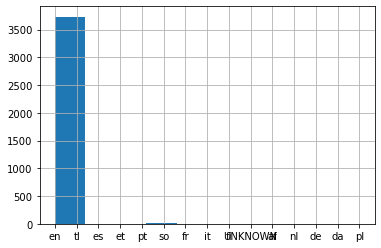

In [16]:
df['language'].hist()

Wow! Almost every song is in english. So, obviously this will be the main language in the corpus. However, let's put the spotlight in those minoritary languages, it does not seem that they include sufficient enough docs to perform a correct. Thus, let's focus now in this languages songs:

Tne number of non-english songs is 32 which correspond to 0.851% of the dataset


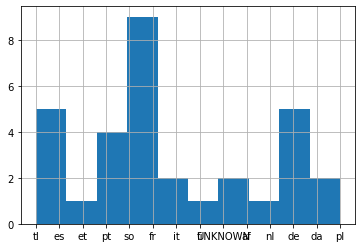

In [17]:
dfNoteng = df.loc[df['language'] != 'en']
dfNoteng['language'].hist()
print(f'Tne number of non-english songs is {dfNoteng.shape[0]} which correspond to {dfNoteng.shape[0]/df.shape[0]*100:.3f}% of the dataset')

It is less than a 1% of the total songs and the most repeated language is 'tagalog' which is a philipine language and are 6 instances of this language. Therefore it is assumible the loss of these instances. Therefore, after this deletion it is our time to apply our spicy Pipeline after the creation of the corpus.

In [18]:
df = df.loc[df['language'] == 'en'].reset_index(drop=True)

corpus = [elem for elem in df['correctLyrics']]

with open('corpus.txt', 'w+') as c:
    c.write(str(corpus))

``corpus`` variable is composed by a long list including every song on it. We have done is in this way because we think Python lists for this kind of task would be faster than using Pandas Dataframes. From this we will create a Pipeline simiarily as we did in classes notebook and use further machine learning algorithm as final work statement requests.

Once the ``corpus`` has been created, it is very easy to apply a Pipeline:

In [19]:
from num2words import num2words
from tqdm import tqdm
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stopwords_en = stopwords.words('english')
wnl = WordNetLemmatizer()

#IMPORT CORPUS
with open('corpus.txt', 'r') as c:
    corpus = eval(c.read())
##############

valid_POS = set(['VERB', 'NOUN', 'ADJ', 'PROPN', 'NUM'])

def convertNum2words(token):
    try:
        return num2words(token)
    except:
        return token

def corpusPreprocessing(song):
    #1. Tokenization
    doc = wordpunct_tokenize(song)
    #2. Filtering by Alphanumeric and Lower the Text
    lowerToken = [token.lower() for token in doc if token.isalnum()]
    tokenList = [convertNum2words(token) for token in lowerToken]
    #3. Lemmatization of the data
    lemmaList = [wnl.lemmatize(el) for el in tokenList]
    #4. Cleanning StopWords
    finalCorpus = [lemma for lemma in lemmaList if lemma not in stopwords_en]
    return finalCorpus

corpus = [corpusPreprocessing(s) for s in tqdm(corpus)]

100%|██████████| 3729/3729 [00:23<00:00, 157.82it/s]


In [20]:
#SAVE CORPUS
with open('corpus.txt', 'w+') as c:
    c.write(str(corpus))
##############

It is surprisingly fast compared to the Pipeline provided by SpaCy. In only took 33 seconds which is 10 times less than the previous Pipeline we constructed but we decided to rewrite it because of the lack of performance and .lower() was not available. Anyway, we decided to store this new corpus inside a txt file such as a 'checkpoint' to save time as much as possible.

### **1.2 Text Vectorization**

Now it is the moment of use N-Grams from ``gensim`` library in order to group in the same token those words that has a tendency of appear together:

In [21]:
#IMPORT CORPUS
with open('corpus.txt', 'r') as c:
    corpus = eval(c.read())
##############
from tqdm import tqdm
from gensim.models.phrases import Phrases

phrase_model = Phrases(corpus, min_count=2, threshold=20)

corpus = [el for el in tqdm(phrase_model[corpus])]

100%|██████████| 3729/3729 [00:02<00:00, 1424.90it/s]


Finally, in order to find a BoW and TF-IDF representation from our corpus, it is necessary to create previously a Gensim Dictionary where the songs will be stored. Once it is created, we can't include more instances, therefore this step is only made when the corpus has been finished.

In [22]:
from gensim.corpora import Dictionary

# Create dictionary of tokens
D = Dictionary(corpus)

print('Our dictionary contains', len(D), 'terms')

Our dictionary contains 78940 terms


Wow! more than 70000 terms in our diccionary. Compared to what we saw from IMBD dataset, this ones contains more items. However, this is not definitive, probably there are several terms that appears barely compared to from what we see in the IMBD which maybe follows a similar structure since a review could be good, bad but nothing else. Let's filter our Diccionary and we will see which are the real tokens that we will need to analyse:

In [23]:
D.filter_extremes(no_below=3,no_above=.80)

print('Our dictionary contains', len(D), 'terms')

Our dictionary contains 24465 terms


Now it makes sense, it decreased drastically and now it seems to be a good bunch of woords to work with. Now it is the moment to introduce clasical representations which using Gensim is quite easy:

In [24]:
from gensim.models import TfidfModel

bow_songs = [D.doc2bow(doc) for doc in corpus] #bow gensim corpus
tfidf = TfidfModel(bow_songs)
tfidf_songs = tfidf[bow_songs]

print(bow_songs[1])
print(tfidf_songs[1])

[(3, 16), (5, 1), (10, 2), (11, 1), (17, 1), (19, 1), (20, 12), (21, 1), (23, 1), (25, 3), (28, 3), (33, 1), (37, 1), (38, 12), (40, 4), (43, 1), (46, 6), (47, 1), (65, 2), (67, 1), (68, 9), (69, 2), (72, 2), (75, 1), (77, 1), (78, 3), (82, 5), (83, 1), (85, 1), (87, 4), (91, 4), (95, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 3), (103, 2), (104, 1), (105, 1), (106, 1), (107, 5), (108, 1), (109, 1), (110, 1), (111, 2), (112, 2), (113, 2), (114, 2), (115, 13), (116, 4), (117, 1), (118, 1), (119, 1), (120, 1), (121, 1), (122, 1), (123, 1), (124, 6), (125, 1), (126, 2), (127, 3), (128, 2), (129, 1), (130, 6), (131, 1), (132, 1), (133, 1), (134, 1), (135, 1), (136, 1), (137, 1), (138, 1), (139, 1), (140, 1), (141, 1), (142, 2), (143, 4), (144, 2), (145, 1), (146, 1), (147, 1), (148, 1), (149, 1), (150, 1), (151, 1), (152, 2), (153, 1), (154, 1), (155, 1), (156, 1), (157, 1), (158, 1), (159, 3), (160, 2), (161, 1), (162, 1), (163, 1), (164, 1), (165, 2), (166, 1), (167, 1), (1

Therefore, this is our first figures obteinment from the words appearing in the lyrics song. Nevertheless, this is not enough to predict properly which genre our song has. This representation just considers the frequency of appearing but not the relation among words. For example, in this song ```Hey Jude - The Beatles``, word 'na' which is some kind of musical onomatopoeia is repeated several times during the song, and its score is 0.88 in the TF-IDF representation which is really high despite it does not meaning anything the word by itself. But is not that bad, for example 'na' expresion could directly being related to rock song, we do not know how the classification model will behave. Furthermore, these kind of representations will be very useful for the developement of more complex models thus it is essential to save them in a variable for future usages.

Without any more introduction, it is the moment to start developing further text-figure extraction models in order to obtain better insights from our data:

As our objective is to make a classification by genre, we will develop 3 different approaches to see which of them works better:

1) The first will be based on a Word2Vec, we will train our own word2vec with the lyrics of the songs of the data set and after that they will be combined with basic classical machine learning models.
2) To compare how word2vec works with a bigger base of embeedings, we will try also a pre-trained model, using for the classification also machine learning models.
3) The third way will be a FastText representation combined with a MLP Neural Network.

So let's create first the representations:

#### **1.2.1 Word2Vec Representation**

##### **1.2.1.1 Word2Vec Representation with our Data**


From the corpus file in which we have all the lyrics cleaned and converted in tokens, we create the word2vec. 

We implement a seed to work in so we can keep track of the results. And we will try with a vector size of 200 for the embeeding size.

In [25]:
#WORD2VEC 

from gensim.models import Word2Vec

model_w2v = Word2Vec(corpus, vector_size=200, seed= 33)

Check the results of the word2vec:

In [26]:
words = list(model_w2v.wv.key_to_index)
print(words[0:50]) #first 50 words
print('\n============= Embedding of the first word =============')
print(model_w2v.wv[words[0]])
print(model_w2v.wv[words[0]].shape)

['wa', 'like', 'got', 'love', 'know', 'get', 'one', 'want', 'baby', 'time', 'go', 'would', 'come', 'see', 'going', 'make', 'oh', 'man', 'yeah', 'back', 'way', 'never', 'say', 'nigga', 'take', 'right', 'let', 'cannot', 'life', 'day', 'girl', 'good', 'could', 'thing', 'two', 'said', 'give', 'need', 'tell', 'feel', 'well', 'think', 'night', 'little', 'u', 'still', 'shit', 'keep', 'look', 'eye']

============= Embedding of the first word =============
[-0.35633123 -0.65573406  0.6324914   0.5553358  -0.07175688  0.6284817
 -0.3340926  -0.7393087  -0.84120125  0.79238135 -0.05857508  0.14053103
  0.75815326 -0.0111374   0.9429879   0.00651788 -0.40393272 -0.12435041
  0.41853553 -0.33340287 -0.718116   -0.10276466  0.9330045   0.20495953
 -0.17411748  0.03952269  1.1347082  -1.5307131   0.644882   -0.9295283
  0.7720839   1.3365684  -0.36532938  0.656959    0.3390927   0.29441804
 -0.10325693 -0.6175142   0.971814    1.0093685  -1.1485531   0.2582945
  0.14529043 -0.47650722 -0.03347995  0.

Save the w2v model in a KeyedVectors, that will result in a smaller and faster object thanks to the mapping between keys and vectors:

In [27]:
from gensim.models import KeyedVectors

# Store just the words + their trained embeddings.
word_vectors = model_w2v.wv
word_vectors.save("model_w2v_imbd_sampling03.wordvectors")

# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("model_w2v_imbd_sampling03.wordvectors", mmap='r')
print(len(wv))
import gc
del model_w2v
gc.collect()

22175


0

Let's visualize the embeedings that will help to know the performance of the model.

We know we can do this thanks to the t-SNE implemented in Sklearn, that reduces high dimensional data to 2 or 3 dimensions keeping as much information as possible.

So let's have a look into out space of embeedings to have a first impression on how the word2vec has separated the words:

c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


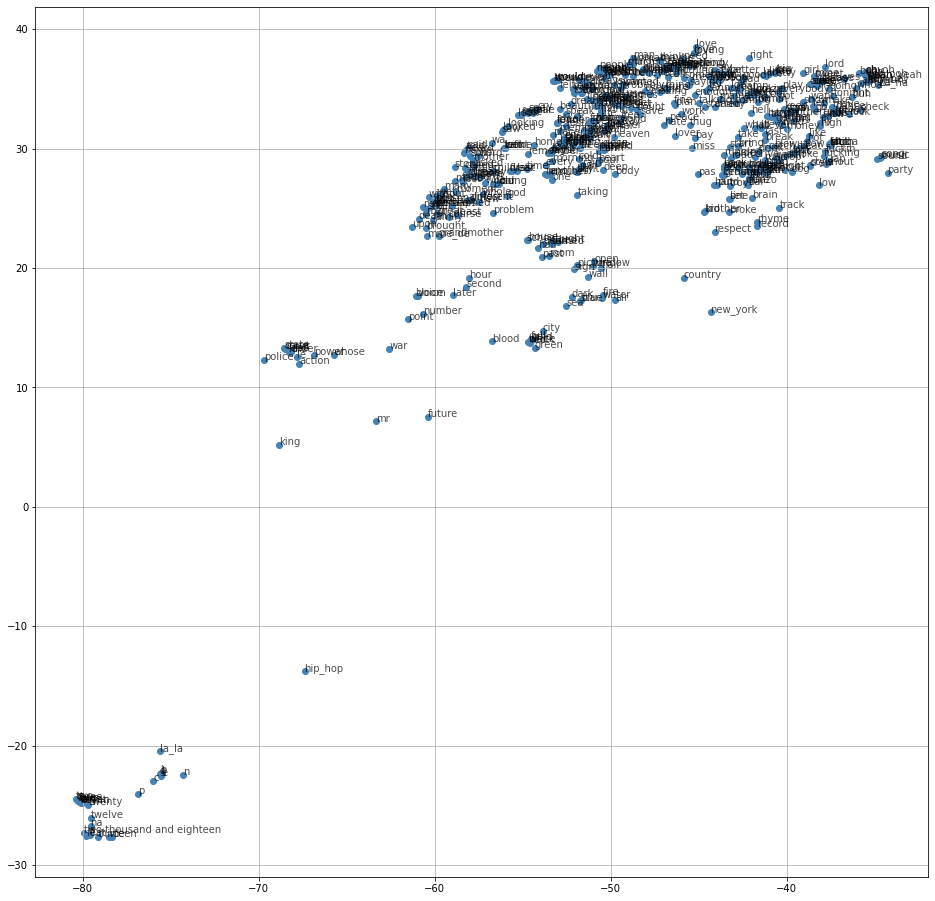

In [28]:
from sklearn.manifold import TSNE

tsne = TSNE(init='random')
embed_tsne = tsne.fit_transform(wv.vectors)

# We plot only 500 embeddings
fig, ax = plt.subplots(figsize=(16, 16))
for idx, word in enumerate((list(wv.key_to_index.keys())[:500])):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(word, (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
      
plt.grid()

In [29]:
del embed_tsne #clean memory
gc.collect()

35

So, what is left is to create a function that can link the keyed Vectors to the list of tokens representing the songs lyrics, and results in the embeeding vector of the lyrics of each song made by the vectors of the words that conform that song.

In [30]:
def get_lyrics_vector(model, lyrics):
  vectors = []
  for token in lyrics:
      if token in model:
          vectors.append(model[token])
  if len(vectors) == 0:
      # If all tokens are OOV, return a vector of zeros
      return np.zeros(model.vector_size)
  else:
      return np.mean(vectors, axis=0)

lyrics_embeddings = []
for i in corpus:
    lyrics_embeddings.append(get_lyrics_vector(wv, i))


In [39]:
print(lyrics_embeddings[0])
print(len(lyrics_embeddings[0])) #we can see each of them has 300 dimensions
print(len(lyrics_embeddings)) #equals the number of songs

[-0.34024054 -0.34099832  0.1275118   0.17957471  0.47045708  0.21442868
 -0.22241944 -0.06566223 -0.02512254  0.50733197 -0.35150534  0.3548891
  0.28902465  0.33222342  0.36462018 -0.20703064  0.18621247 -0.1548699
 -0.18525113  0.06981155 -0.1129395   0.04671338 -0.12437516 -0.1683894
  0.24672212 -0.20857668  0.48330906 -0.41569105  0.4936307   0.10206272
  0.00366528 -0.06872773  0.24252291 -0.12071206 -0.05169732 -0.29853722
  0.10333535  0.4116969  -0.02614379  0.13123196 -0.39427423 -0.07435802
 -0.161554   -0.04812155 -0.11069191  0.06166301  0.05101025  0.11450924
  0.03337283  0.26355198 -0.11414315  0.06241149 -0.31148526 -0.30416027
 -0.189083   -0.14020878  0.16355138  0.20140123 -0.30399132  0.36967835
  0.25372925  0.0654505   0.18276478 -0.27855584  0.22202608 -0.2823547
 -0.18411104 -0.03128278  0.34228042  0.8285372  -0.09543537  0.17113425
  0.1763559  -0.7858172   0.18085197  0.05716765  0.45068422  0.1978453
 -0.28808782 -0.51122916  0.58849704 -0.30636755  0.1093

##### CLASSIFICATION

Now that we have the embeedings of the lyrics, created and based in a word2vec modeled with the own songs, we have a representation of the lyrics in numbers, so we will work with some machine learning classifiers and see how wll they can classify by genre in <b>section 2<b>

##### **1.2.1.2 Word2Vec with Pre-Trained Model**

From the gensim documentation we decided to use the pre-trained model: "word2vec-google-news-300", that has 300 dimensions, which should be fine and enough for our objective.


In [1]:
import gensim.downloader as api

pre_w2v = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [33]:
print(type(pre_w2v))


<class 'gensim.models.keyedvectors.KeyedVectors'>


We can see that now we have directly a keyedvectors object, with the mapping between keys and vectors.

So we can directly pass to link the tokens we have in each of our songs's lyrics with the corresponding vector of our new keyed vectors object:

In [34]:
def get_lyrics_vector(model, lyrics):
  vectors = []
  for token in lyrics:
      if token in model:
          vectors.append(model[token])
  if len(vectors) == 0:
      # If all tokens are OOV, return a vector of zeros
      return np.zeros(model.vector_size)
  else:
      return np.mean(vectors, axis=0)

lyrics_embeddings_pre = []
for i in corpus:
    lyrics_embeddings_pre.append(get_lyrics_vector(pre_w2v, i))

In [38]:
print(lyrics_embeddings_pre[0])
print(len(lyrics_embeddings_pre[0])) #we can see each of them has 300 dimensions
print(len(lyrics_embeddings_pre)) #equals the number of songs

[ 0.03764191  0.01680911  0.02917939  0.07250047 -0.06872599 -0.0527283
  0.04931778 -0.07780812  0.10342871  0.1155538  -0.06705698 -0.10832203
 -0.06433553  0.02791469 -0.08942156  0.07580641  0.06468143  0.09460323
  0.02160174 -0.08267625 -0.01490749  0.08382135  0.07986633 -0.04091013
  0.06311885 -0.0069638  -0.06185263 -0.01732039  0.05336882 -0.04841734
 -0.07339673  0.04897331 -0.05919791 -0.01851171 -0.02823274 -0.08294087
  0.0716463  -0.02210689  0.04641913  0.09102935  0.06469021 -0.0963939
  0.13705072 -0.07202254 -0.03410276 -0.03430087 -0.0905313   0.00619811
 -0.00997948  0.06349027 -0.07168807  0.08087606  0.00952997 -0.00062997
  0.04841442  0.00883186 -0.04402878 -0.09251373  0.05344151 -0.04804488
 -0.01371192  0.03545097 -0.05698254 -0.03032231  0.00857108 -0.05201145
 -0.05650203  0.07186534 -0.10086951  0.06021252  0.04317943  0.03024957
  0.07271444 -0.00274859 -0.15255405 -0.06716308  0.06744245  0.05934751
  0.04092354  0.10571897  0.01696628 -0.03543182  0.0

So we are ready again to pass to the classification task, and see the difference between the word2vec created by ourselves with the data we have, and a much bigger pre-trained model linked afterwards with our lyrics.

#### **1.2.2 FastText Representation**

In [ ]:
#TODO
#FASTTEXT

### **1.3 Topic Modeling**

In [ ]:
#TODO

#TOPIC SELECTION
#SEMANTIC SIMILARITY-LDA

## **2.Machine Learning Model**

### **2.1 Classification Task**

#### **2.1.1 Machine Learning Approach**

#### **2.1.1.1 Machine Learning Approach with self-created word2vec**

First we have to split the data and create an embeedings matrix:

In [41]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
import random
random.seed(33)

#1) SPlit the data
X_train, X_test, y_train, y_test = train_test_split(df['correctLyrics'], df['type'], test_size=0.3, random_state=33)

#2)Embeedings matrix
size_embeding = len(lyrics_embeddings[0])
X_train_emb = np.zeros((len(X_train), size_embeding))
for i, review in enumerate(X_train):
    X_train_emb[i] = get_lyrics_vector(wv, review)


##### -SVM

In [56]:
#3)Train with different hyper parameters the classifier and obtain the best result
random.seed(33)
svm = SVC()
param_grid = {'C': [1,3,5,7,9], 'kernel': ['rbf', 'linear']}
svm_grid_search = GridSearchCV(svm, param_grid, cv=5)
svm_grid_search.fit(X_train_emb, y_train)

# Evaluate the performance of the classifier on the test set
X_test_emb = np.zeros((len(X_test), size_embeding))
for i, review in enumerate(X_test):
    X_test_emb[i] = get_lyrics_vector(wv, review)

svm_best = svm_grid_search.best_estimator_
svm_accuracy = svm_best.score(X_test_emb, y_test)
svm_accuracy_train = svm_best.score(X_train_emb, y_train)


print(f"SVM accuracy on the train set: {svm_accuracy_train:.4f}")
print(f"SVM accuracy on the test set: {svm_accuracy:.4f}")
print("Best SVM parameters are: ", svm_best)

SVM accuracy on the train set: 0.4454
SVM accuracy on the test set: 0.4540
Best SVM parameters are:  SVC(C=5, kernel='linear')


##### -KNN

In [57]:
from sklearn.neighbors import KNeighborsClassifier

random.seed(33)
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [1,5,10,15,20,25,30,35,40]}
knn_grid_search = GridSearchCV(knn, param_grid, cv=5)
knn_grid_search.fit(X_train_emb, y_train)

# Evaluate the performance of the classifier on the test set
X_test_emb = np.zeros((len(X_test), size_embeding))
for i, review in enumerate(X_test):
    X_test_emb[i] = get_lyrics_vector(wv, review)


knn_best = knn_grid_search.best_estimator_
knn_accuracy = knn_best.score(X_test_emb, y_test)
knn_accuracy_train = knn_best.score(X_train_emb, y_train)


print(f"KNN accuracy on the train set: {knn_accuracy_train:.4f}")
print(f"KNN accuracy on the test set: {knn_accuracy:.4f}")
print("Best knn parameters are: ", knn_best)

KNN accuracy on the train set: 0.5109
KNN accuracy on the test set: 0.4236
Best knn parameters are:  KNeighborsClassifier(n_neighbors=15)


##### -Random Forest

In [68]:
from  sklearn.ensemble import RandomForestClassifier

random.seed(33)
RF = RandomForestClassifier()
param_grid = {'n_estimators': [50,100,200,400], 'criterion':['gini', 'entropy'], 'max_depth':[2,5,10,15]}
RF_grid_search = GridSearchCV(RF, param_grid, cv=5)
RF_grid_search.fit(X_train_emb, y_train)

# Evaluate the performance of the classifier on the test set
X_test_emb = np.zeros((len(X_test), size_embeding))
for i, review in enumerate(X_test):
    X_test_emb[i] = get_lyrics_vector(wv, review)


RF_best = RF_grid_search.best_estimator_
RF_accuracy = RF_best.score(X_test_emb, y_test)
RF_accuracy_train = RF_best.score(X_train_emb, y_train)


print(f"RF accuracy on the train set: {RF_accuracy_train:.4f}")
print(f"RF accuracy on the test set: {RF_accuracy:.4f}")
print("Best RF parameters are: ", RF_best)

RF accuracy on the train set: 0.9943
RF accuracy on the test set: 0.4781
Best RF parameters are:  RandomForestClassifier(criterion='entropy', max_depth=15, n_estimators=400)


##### -Multinomial Logistic Regression

In [78]:
from sklearn.linear_model import LogisticRegression

random.seed(33)
lr = LogisticRegression()
param_grid = {'multi_class':['multinomial', 'ovr'], 'solver':['lbfgs'], 'C':[0.0001, 0.001, 0.01, 0.1, 0.5,1]}
lr_grid_search = GridSearchCV(lr, param_grid, cv=5)
lr_grid_search.fit(X_train_emb, y_train)

# Evaluate the performance of the classifier on the test set
X_test_emb = np.zeros((len(X_test), size_embeding))
for i, review in enumerate(X_test):
    X_test_emb[i] = get_lyrics_vector(wv, review)


lr_best = lr_grid_search.best_estimator_
lr_accuracy = lr_best.score(X_test_emb, y_test)
lr_accuracy_train = lr_best.score(X_train_emb, y_train)


print(f"Logistic Regression accuracy on the train set: {lr_accuracy_train:.4f}")
print(f"LR accuracy on the test set: {lr_accuracy:.4f}")
print("Best LR parameters are: ", lr_best)

c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Logistic Regression accuracy on the train set: 0.4374
LR accuracy on the test set: 0.4298
Best LR parameters are:  LogisticRegression(C=1, multi_class='multinomial')


#### **2.1.1.2 Machine Learning Approach with pre-trained word2vec**

We will follow exactly the same steps we have done with our word2vec, so we can compare the results in terms of accuracy of the classification.

In [42]:
random.seed(33)

#1) SPlit the data
X_train, X_test, y_train, y_test = train_test_split(df['correctLyrics'], df['type'], test_size=0.3, random_state=33)

#2)Embeedings matrix
size_embeding_pre = len(lyrics_embeddings_pre[0])
X_train_emb = np.zeros((len(X_train), size_embeding_pre))
for i, review in enumerate(X_train):
    X_train_emb[i] = get_lyrics_vector(pre_w2v, review)


##### -SVM

In [43]:
#3)Train with different hyper parameters the classifier and obtain the best result
random.seed(33)
svm = SVC()
param_grid = {'C': [1,3,5,7,9], 'kernel': ['rbf', 'linear']}
svm_grid_search = GridSearchCV(svm, param_grid, cv=5)
svm_grid_search.fit(X_train_emb, y_train)

# Evaluate the performance of the classifier on the test set
X_test_emb = np.zeros((len(X_test), size_embeding_pre))
for i, review in enumerate(X_test):
    X_test_emb[i] = get_lyrics_vector(pre_w2v, review)

svm_best = svm_grid_search.best_estimator_
svm_accuracy = svm_best.score(X_test_emb, y_test)
svm_accuracy_train = svm_best.score(X_train_emb, y_train)


print(f"SVM accuracy on the train set: {svm_accuracy_train:.4f}")
print(f"SVM accuracy on the test set: {svm_accuracy:.4f}")
print("Best SVM parameters are: ", svm_best)

SVM accuracy on the train set: 0.5418
SVM accuracy on the test set: 0.5353
Best SVM parameters are:  SVC(C=7)


##### -KNN

In [44]:
from sklearn.neighbors import KNeighborsClassifier

random.seed(33)
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [1,5,10,15,20,25,30,35,40]}
knn_grid_search = GridSearchCV(knn, param_grid, cv=5)
knn_grid_search.fit(X_train_emb, y_train)

# Evaluate the performance of the classifier on the test set
X_test_emb = np.zeros((len(X_test), size_embeding_pre))
for i, review in enumerate(X_test):
    X_test_emb[i] = get_lyrics_vector(pre_w2v, review)


knn_best = knn_grid_search.best_estimator_
knn_accuracy = knn_best.score(X_test_emb, y_test)
knn_accuracy_train = knn_best.score(X_train_emb, y_train)


print(f"KNN accuracy on the train set: {knn_accuracy_train:.4f}")
print(f"KNN accuracy on the test set: {knn_accuracy:.4f}")
print("Best knn parameters are: ", knn_best)

KNN accuracy on the train set: 0.5502
KNN accuracy on the test set: 0.4727
Best knn parameters are:  KNeighborsClassifier(n_neighbors=10)


##### -Random Forest

In [45]:
from  sklearn.ensemble import RandomForestClassifier

random.seed(33)
RF = RandomForestClassifier()
param_grid = {'n_estimators': [50,100,200,400], 'criterion':['gini', 'entropy'], 'max_depth':[2,5,10,12]}
RF_grid_search = GridSearchCV(RF, param_grid, cv=5)
RF_grid_search.fit(X_train_emb, y_train)

# Evaluate the performance of the classifier on the test set
X_test_emb = np.zeros((len(X_test), size_embeding_pre))
for i, review in enumerate(X_test):
    X_test_emb[i] = get_lyrics_vector(pre_w2v, review)


RF_best = RF_grid_search.best_estimator_
RF_accuracy = RF_best.score(X_test_emb, y_test)
RF_accuracy_train = RF_best.score(X_train_emb, y_train)


print(f"RF accuracy on the train set: {RF_accuracy_train:.4f}")
print(f"RF accuracy on the test set: {RF_accuracy:.4f}")
print("Best RF parameters are: ", RF_best)

RF accuracy on the train set: 0.9866
RF accuracy on the test set: 0.5657
Best RF parameters are:  RandomForestClassifier(max_depth=12, n_estimators=400)


##### -Multinomial Logistic Regression

In [46]:
from sklearn.linear_model import LogisticRegression

random.seed(33)
lr = LogisticRegression()
param_grid = {'multi_class':['multinomial', 'ovr'], 'solver':['lbfgs'], 'C':[0.0001, 0.001, 0.01, 0.1, 0.5,1]}
lr_grid_search = GridSearchCV(lr, param_grid, cv=5)
lr_grid_search.fit(X_train_emb, y_train)

# Evaluate the performance of the classifier on the test set
X_test_emb = np.zeros((len(X_test), size_embeding_pre))
for i, review in enumerate(X_test):
    X_test_emb[i] = get_lyrics_vector(pre_w2v, review)


lr_best = lr_grid_search.best_estimator_
lr_accuracy = lr_best.score(X_test_emb, y_test)
lr_accuracy_train = lr_best.score(X_train_emb, y_train)


print(f"Logistic Regression accuracy on the train set: {lr_accuracy_train:.4f}")
print(f"LR accuracy on the test set: {lr_accuracy:.4f}")
print("Best LR parameters are: ", lr_best)

c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\34649\anaconda3\envs\ML\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Logistic Regression accuracy on the train set: 0.5184
LR accuracy on the test set: 0.5130
Best LR parameters are:  LogisticRegression(C=1, multi_class='multinomial')


We can see the results are better with the pre-trained model, what is in fact, what we expected, as word2vec works better with more words, and our self created model based on the lyrics of the song was not speccially big.

#### **2.1.2 Deep Learning Approach**

In [ ]:
#TODO
#NEURAL NETWORK IN CLASS

### **2.2 Clustering Task**

In [ ]:
#TODO
#UNSUPERVISED LEARNING REGARDING CLUSTERING